## Shopee 데이터를 이용한 유사 상품 이미지 매칭모델 만들기

Source : https://www.kaggle.com/competitions/shopee-product-matching

### 1. 라이브러리 불러오기

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# utils
import os
from glob import glob
from termcolor import colored

# for data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# for image
import cv2
from PIL import Image

# for KNN Search (ML)
from sklearn.neighbors import NearestNeighbors

# for image embedding (DL)
import tensorflow as tf
from tensorflow.keras.applications import ResNet101

### 2. 데이터 불러오기

In [4]:
base_path = "/content/drive/MyDrive/Colab Notebooks/data/shopee_samples/"
train = pd.read_csv(base_path + "train_samples.csv")
test = pd.read_csv(base_path + "test.csv")

In [5]:
train

,posting_id,image,image_phash,title,label_group
0,train_1449570166,004ede0e328d05780813f853857463f1.jpg,c1d43c3f1f949685,Citra Tone Up Pearly White Body Lotion 180 ml ...,3578753118
1,train_1015862061,00ee86a6810cd9f2da6dd0f0f01b867f.jpg,ba9ce0331b624eb6,[ Promo Flash Sale ] Luvita Dress | Size S M L...,3687627144
2,train_3357525517,0105b22c32a9b701766be74953fb9570.jpg,bea5d32c611aa56a,Pantene Conditioner 3 Minutes Miracle Quantum ...,2573756909
3,train_3741232712,0163ecd19e6977a81e29c75252029533.jpg,e2969a6b983349b3,GAMIS PLISKET ANAK PEREMPUAN 3-10 TAHUN/PAKAIA...,3602809108
4,train_303300793,0174cc0f9dbf096873b3e103ae0576a8.jpg,ea859568947ac53d,Belfoods Uenaaak Nugget Ayam Stick 500gr,1634389569
...,...,...,...,...,...
992,train_2946175115,fe9c42d00d836b69e7d9b2e2170624cb.jpg,8b86f8bf483a9645,WALLPAPER DINDING DANDELION BIRU ukuran 45 cm ...,153202204
993,train_18617839,feed2edfb91f2a2ecc33ce23efba42d6.jpg,bada4a833193da8d,BELI 10 GRATIS 1 SILICA GEL BLUE GRADE A ISI 1...,673728657
994,train_2577029445,feefe971e39f9fc915c22841a149c0b3.jpg,fa25c38a96d73930,MINISO Mouse Pad XL Gaming Mouse Pad Desktop A...,2873913351
995,train_714150854,ff15a44141007366f2f21289c345ee37.jpg,fac1853a2f567a81,"b""Huki dot silicone s '3 (gepeng)""",235634780


In [ ]:
test

,posting_id,image,image_phash,title
0,test_2255846744,0006c8e5462ae52167402bac1c2e916e.jpg,ecc292392dc7687a,Edufuntoys - CHARACTER PHONE ada lampu dan mus...
1,test_3588702337,0007585c4d0f932859339129f709bfdc.jpg,e9968f60d2699e2c,(Beli 1 Free Spatula) Masker Komedo | Blackhea...
2,test_4015706929,0008377d3662e83ef44e1881af38b879.jpg,ba81c17e3581cabe,READY Lemonilo Mie instant sehat kuah dan goreng


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 997 entries, 0 to 996
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   posting_id   997 non-null    object
 1   image        997 non-null    object
 2   image_phash  997 non-null    object
 3   title        997 non-null    object
 4   label_group  997 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 39.1+ KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   posting_id   3 non-null      object
 1   image        3 non-null      object
 2   image_phash  3 non-null      object
 3   title        3 non-null      object
dtypes: object(4)
memory usage: 224.0+ bytes


### 3. EDA

#### 3-1. Target value EDA

In [ ]:
print(f"Number of Unique Label Groups: {colored(train.label_group.nunique(), 'yellow')}")

Number of Unique Label Groups: 939


,Id,Count
0,3627744656,5
1,1163569239,4
2,3001123709,3
3,3206118280,3
4,3639207904,2
5,2151413694,2
6,2142919313,2
7,3741568948,2
8,2333435384,2
9,952183003,2


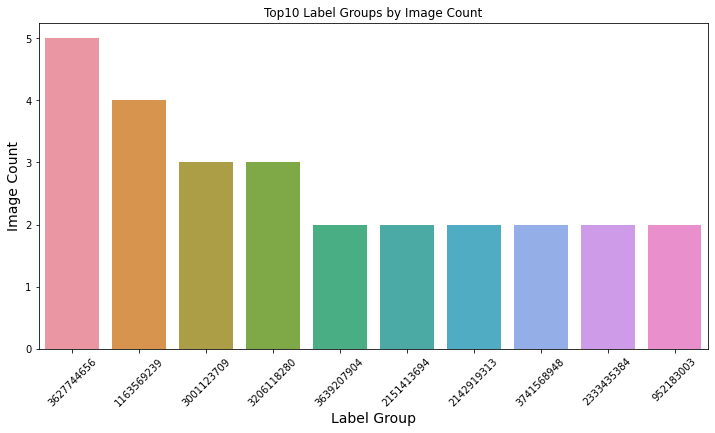

In [6]:
# show top10

top10 = train.label_group.value_counts()[:10]
top10_df = pd.DataFrame({"Id" : top10.index, "Count" : top10.values})
display(top10_df)

plt.figure(figsize=(12, 6))
sns.set_palette("Set2")
sns.barplot(data=top10_df, x="Id", y="Count", order=top10_df.Id)
plt.xticks(rotation=45)
plt.xlabel("Label Group", fontsize=14)
plt.ylabel("Image Count", fontsize=14)
plt.title("Top10 Label Groups by Image Count")
plt.show()

#### 3-2. Image features EDA

In [8]:
train_img_folder = base_path + "train_images/"
test_img_folder = base_path + "test_images/"

In [9]:
def getImagePaths(path):
    image_paths = glob(path + "*.jpg")
    return image_paths

In [10]:
train_img_paths = getImagePaths(train_img_folder)
test_img_paths = getImagePaths(test_img_folder)

In [12]:
print(f"Number of train images: {len(train_img_paths)}\n")
print(f"Number of test images: {len(test_img_paths)}\n")

Number of train images: 997

Number of test images: 3



In [13]:
def get_image_Shape(img_paths):
    shape = cv2.imread(img_paths[0]).shape
    for img_path in img_paths:
        img_shape = cv2.imread(img_path).shape
        if img_shape != shape:
            return f"Has Different image shape in {img_path} with {img_shape}."
        else:
            return f"Has Same image shape, {shape}"

In [14]:
print(get_image_Shape(train_img_paths))
print(get_image_Shape(test_img_paths))

Has Same image shape, (640, 640, 3)
Has Same image shape, (1000, 1000, 3)


In [15]:
def get_image_pixelmat(img_path):
    img = cv2.imread(img_path)
    print("Min pixel value : ", np.min(img))
    print("Max pixel value : ", np.max(img))

    pixel_matrix = np.reshape(img, (img.shape[0] * img.shape[1], img.shape[2]))
    print("Shape of pixel matrix : ", pixel_matrix.shape)
    return pixel_matrix

In [16]:
get_image_pixelmat(train_img_paths[0])

Min pixel value :  0
Max pixel value :  255
Shape of pixel matrix :  (409600, 3)


array([[ 66,  91, 131],
       [ 65,  90, 130],
       [ 63,  88, 128],
       ...,
       [101, 112, 120],
       [ 98, 109, 117],
       [ 97, 108, 116]], dtype=uint8)

In [17]:
def display_multiple_img(img_paths, nrows, ncols, title):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 8))
    plt.suptitle(title, fontsize=20)
    for idx, img_path in enumerate(img_paths):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        try:
            ax.ravel()[idx].imshow(img)
            ax.ravel()[idx].set_axis_off()
        except:
            continue
    plt.tight_layout()
    plt.show()

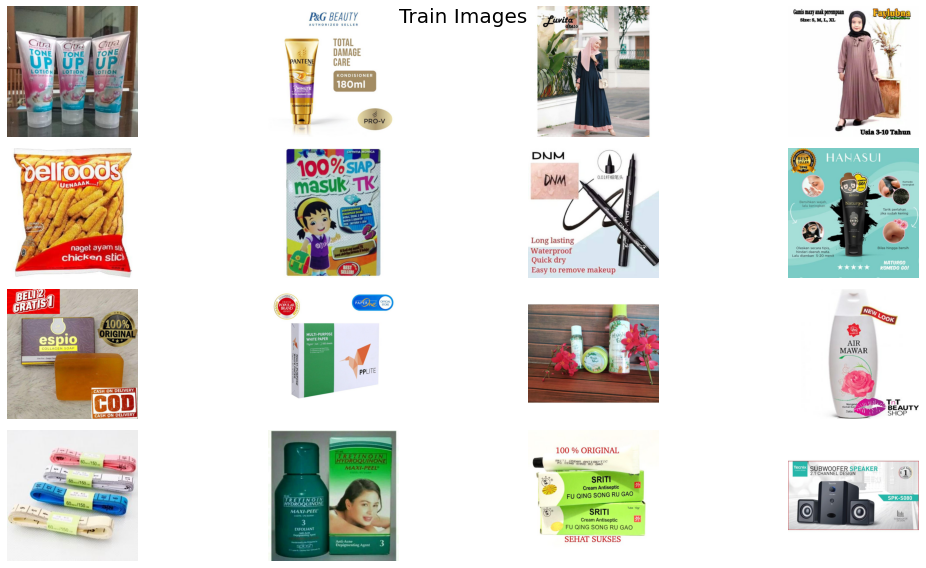

In [18]:
display_multiple_img(train_img_paths[0:16], 4, 4, "Train Images")

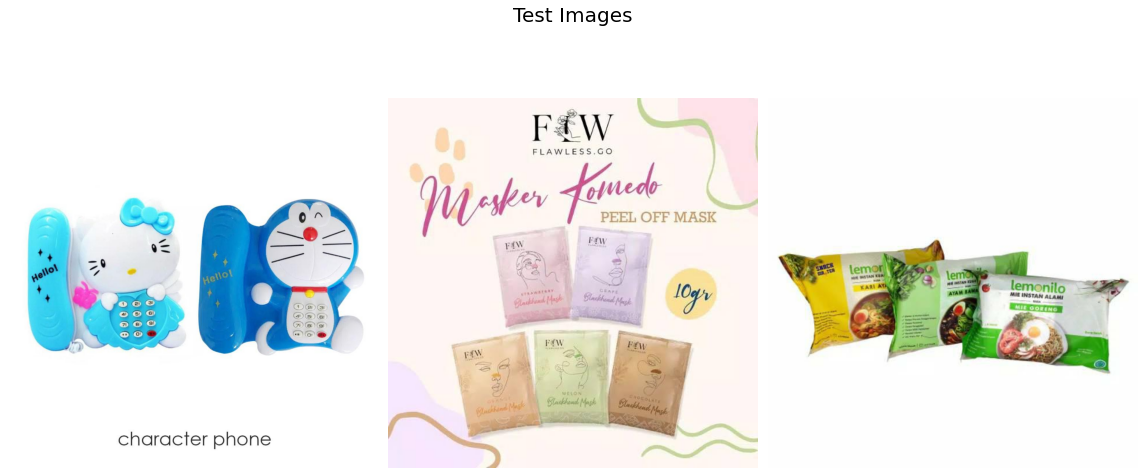

In [ ]:
display_multiple_img(test_img_paths, 1, 3, "Test Images")

### 4. 이미지 임베딩하여 가까운 이미지 찾기

- pretrained model(ResNet 101)을 이용하여 Image를 embedding vector로 만듭니다.

- KNN Search를 이용하여 가까운 이미지를 찾습니다.

In [20]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, df, img_size=256, batch_size=32, path=train_img_folder): 
        self.df = df
        self.img_size = img_size
        self.batch_size = batch_size
        self.path = path
        self.indexes = np.arange(len(self.df))
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        ct = len(self.df) // self.batch_size
        ct += int(((len(self.df)) % self.batch_size)!=0)
        return ct

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X = self.__data_generation(indexes)
        return X
            
    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' 
        X = np.zeros((len(indexes),self.img_size,self.img_size,3),dtype='float32')
        df = self.df.iloc[indexes]
        for i,(index,row) in enumerate(df.iterrows()):
            img = cv2.imread(self.path+row.image)
            X[i,] = cv2.resize(img,(self.img_size,self.img_size))
        return X

In [21]:
model = ResNet101(weights="imagenet", include_top=False, pooling="avg", input_shape=None)
train_gen = DataGenerator(train, batch_size=128)

171446536/171446536 [==============================] - 6s 0us/step


In [ ]:
image_embeddings = model.predict(train_gen, verbose=1)

8/8 [==============================] - 565s 79s/step


In [ ]:
K = 10
knn = NearestNeighbors(n_neighbors=K)
knn.fit(image_embeddings)
distances, indices = knn.kneighbors(image_embeddings)

In [ ]:
ROWS=2
COLS=4
for c in range(5):
    print("Cluster ",c)  
    t = train.loc[(indices[c,:8])]
    for k in range(ROWS):
        plt.figure(figsize=(20,5))
        for j in range(COLS):
            row = COLS*k + j
            name = t.iloc[row,1]
            img = cv2.imread(train_img_folder + name)
            
            #converting from BGR to RGB
            img = img[:, :, ::-1]
            
            plt.subplot(1,COLS,j+1)
            plt.axis('off')
            plt.imshow(img)
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

### References

1. https://en.wikipedia.org/wiki/Data_analysis#Initial_data_analysis

2. https://www.kaggle.com/ishandutta/v7-shopee-indepth-eda-one-stop-for-all-your-needs

3. https://www.kaggle.com/heyytanay/shopee-eda-understanding-the-competition?scriptVersionId=60038837

4. https://www.kaggle.com/ruchi798/shopee-eda-rapids-preprocessing-w-b?scriptVersionId=59674647

5. https://www.kaggle.com/isaienkov/shopee-data-understanding-and-analysis